## Import Library

In [1]:
import os
import numpy as np
import random as python_random
SEED=56789
np.random.seed(SEED)
python_random.seed(SEED)
os.environ['PYTHONHASHSEED']=str(SEED)

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import pickle
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, MACCSkeys
from rdkit.Avalon import pyAvalonTools

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
from math import sqrt

import matplotlib.pyplot as plt

%matplotlib inline

### Versions of all libraries used

In [ ]:
import sys
print("Python version:", sys.version)
print("="*50)

# Core libraries
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")

# Machine learning libraries
import sklearn
print(f"Scikit-learn version: {sklearn.__version__}")
import scipy
print(f"SciPy version: {scipy.__version__}")

# Cheminformatics
try:
    import rdkit
    print(f"RDKit version: {rdkit.__version__}")
except AttributeError:
    # Some RDKit versions don't have __version__
    from rdkit import rdBase
    print(f"RDKit version: {rdBase.rdkitVersion}")

# Environment information
print("="*50)
print(f"Operating System: {os.name}")
if hasattr(os, 'uname'):
    uname = os.uname()
    print(f"System: {uname.sysname} {uname.release}")
    print(f"Machine: {uname.machine}")

print(f"Random seed used: {SEED}")
print("="*50)

Python version: 3.7.7 (default, Mar 26 2020, 15:48:22) 
[GCC 7.3.0]
NumPy version: 1.18.1
Pandas version: 1.0.3
Matplotlib version: 3.1.3
Scikit-learn version: 0.21.3
SciPy version: 1.4.1
RDKit version: 2020.03.3
Operating System: posix
System: Linux 5.15.0-139-generic
Machine: x86_64
Random seed used: 56789


## Read the train and test sets

In [ ]:
train_df_loaded = pd.read_csv('RET_Mutant_train_set.csv')
test_df_loaded = pd.read_csv('RET_Mutant_test_set.csv')

# Extract SMILES and targets from the loaded dataframes
X_train = train_df_loaded['RDKIT_SMILES']
Y_train = train_df_loaded['pIC50']
X_test = test_df_loaded['RDKIT_SMILES']
Y_test = test_df_loaded['pIC50']

print(f"Loaded train set: {len(X_train)} samples")
print(f"Loaded test set: {len(X_test)} samples")
print(f"Train target range: {Y_train.min():.3f} - {Y_train.max():.3f}")
print(f"Test target range: {Y_test.min():.3f} - {Y_test.max():.3f}")

Loaded train set: 696 samples
Loaded test set: 174 samples
Train target range: 5.000 - 8.046
Test target range: 5.000 - 7.836


## Features based on ECFP6

In [4]:
def smiles_to_mols(query_smiles):
    mols = [Chem.MolFromSmiles(smile) for smile in query_smiles]
    valid = [0 if mol is None else 1 for mol in mols]
    valid_idxs = [idx for idx, boolean in enumerate(valid) if boolean == 1]
    valid_mols = [mols[idx] for idx in valid_idxs]
    return valid_mols, valid_idxs

class Descriptors:

    def __init__(self, data):
        self._data = data

    def ECFP(self, radius, nBits):
        fingerprints = []
        mols, idx = smiles_to_mols(self._data)
        fp_bits = [AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits) for mol in mols]
        for fp in fp_bits:
            fp_np = np.zeros((1, nBits), dtype=np.int32)
            DataStructs.ConvertToNumpyArray(fp, fp_np)
            fingerprints.append(fp_np)
        return fingerprints, idx

    def ECFP_counts(self, radius, useFeatures, useCounts=True):
        mols, valid_idx = smiles_to_mols(self._data)
        fps = [AllChem.GetMorganFingerprint(mol, radius, useCounts=useCounts, useFeatures=useFeatures) for mol in mols]
        size = 2048
        nfp = np.zeros((len(fps), size), np.int32)
        for i, fp in enumerate(fps):
            for idx, v in fp.GetNonzeroElements().items():
                nidx = idx % size
                nfp[i, nidx] += int(v)
        return nfp, valid_idx

    def Avalon(self, nBits):
        mols, valid_idx = smiles_to_mols(self._data)
        fingerprints = []
        fps = [pyAvalonTools.GetAvalonFP(mol, nBits=nBits) for mol in mols]
        for fp in fps:
            fp_np = np.zeros((1, nBits), dtype=np.int32)
            DataStructs.ConvertToNumpyArray(fp, fp_np)
            fingerprints.append(fp_np)
        return fingerprints, valid_idx

    def MACCS_keys(self):
        mols, valid_idx = smiles_to_mols(self._data)
        fingerprints = []
        fps = [MACCSkeys.GenMACCSKeys(mol) for mol in mols]
        for fp in fps:
            fp_np = np.zeros((1, ), dtype=np.int32)
            DataStructs.ConvertToNumpyArray(fp, fp_np)
            fingerprints.append(fp_np)
        return fingerprints, valid_idx

def get_ECFP6_counts(inp):
    if not isinstance(inp, list):
        inp = list(inp)
    desc = Descriptors(inp)
    fps, _ = desc.ECFP_counts(radius=3, useFeatures=True, useCounts=True)
    return fps

In [5]:
train_fps = get_ECFP6_counts(X_train)
test_fps = get_ECFP6_counts(X_test)

## Training Model

In [6]:
models_RF_train = {"RF": RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=28,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=270,
                      n_jobs=None, oob_score=False, random_state=1234,
                      verbose=0, warm_start=False)}

## Cross-validation strategy for model evaluation

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer

# Define cross-validation parameters
cv_folds = 5  # Number of folds for cross-validation
cv_random_state = 42  # For reproducible CV splits

# Create KFold cross-validator
kfold = KFold(n_splits=cv_folds, shuffle=True, random_state=cv_random_state)

# Define custom scoring functions for cross-validation
def rmse_scorer(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

def mae_scorer(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def pearson_scorer(y_true, y_pred):
    corr, _ = pearsonr(y_true, y_pred)
    return corr

# Create scikit-learn scorers
rmse_score = make_scorer(rmse_scorer, greater_is_better=False)
mae_score = make_scorer(mae_scorer, greater_is_better=False)
pearson_score = make_scorer(pearson_scorer)

print(f"Cross-validation setup:")
print(f"- Number of folds: {cv_folds}")
print(f"- CV random state: {cv_random_state}")
print(f"- Shuffle enabled: True")
print(f"- Scoring metrics: R², RMSE, MAE, Pearson correlation")

Cross-validation setup:
- Number of folds: 5
- CV random state: 42
- Shuffle enabled: True
- Scoring metrics: R², RMSE, MAE, Pearson correlation


## Perform cross-validation on training data

In [ ]:
# Clear any existing CV results
for var in ['cv_r2_scores', 'cv_rmse_scores', 'cv_mae_scores', 'cv_pearson_scores']:
    if var in globals():
        del globals()[var]

print("\n" + "="*70)
print("           CROSS-VALIDATION RESULTS ON TRAINING DATA")
print("="*70)

rf_model = models_RF_train["RF"]

print("\nPerforming 5-fold cross-validation...")

# R² score
cv_r2_scores = cross_val_score(rf_model, train_fps, Y_train, cv=kfold, scoring='r2')
print(f"\n📊 R² Scores:\n   Individual folds: {[f'{s:.4f}' for s in cv_r2_scores]}")
print(f"   Mean ± Std: {cv_r2_scores.mean():.4f} ± {cv_r2_scores.std():.4f}")

# RMSE
cv_rmse_scores = -cross_val_score(rf_model, train_fps, Y_train, cv=kfold, scoring=rmse_score)
print(f"\n📏 RMSE Scores:\n   Individual folds: {[f'{s:.4f}' for s in cv_rmse_scores]}")
print(f"   Mean ± Std: {cv_rmse_scores.mean():.4f} ± {cv_rmse_scores.std():.4f}")

# MAE
cv_mae_scores = -cross_val_score(rf_model, train_fps, Y_train, cv=kfold, scoring=mae_score)
print(f"\n📐 MAE Scores:\n   Individual folds: {[f'{s:.4f}' for s in cv_mae_scores]}")
print(f"   Mean ± Std: {cv_mae_scores.mean():.4f} ± {cv_mae_scores.std():.4f}")

# Pearson
cv_pearson_scores = cross_val_score(rf_model, train_fps, Y_train, cv=kfold, scoring=pearson_score)
print(f"\n🔗 Pearson Correlation:\n   Individual folds: {[f'{s:.4f}' for s in cv_pearson_scores]}")
print(f"   Mean ± Std: {cv_pearson_scores.mean():.4f} ± {cv_pearson_scores.std():.4f}")

print("\n" + "="*70)
print("Cross-validation completed successfully!")



           CROSS-VALIDATION RESULTS ON TRAINING DATA

Performing 5-fold cross-validation...

📊 R² Scores:
   Individual folds: ['0.4242', '0.4802', '0.5488', '0.4934', '0.4875']
   Mean ± Std: 0.4868 ± 0.0396

📊 R² Scores:
   Individual folds: ['0.4242', '0.4802', '0.5488', '0.4934', '0.4875']
   Mean ± Std: 0.4868 ± 0.0396

📏 RMSE Scores:
   Individual folds: ['0.4658', '0.4739', '0.4226', '0.4529', '0.4493']
   Mean ± Std: 0.4529 ± 0.0175

📏 RMSE Scores:
   Individual folds: ['0.4658', '0.4739', '0.4226', '0.4529', '0.4493']
   Mean ± Std: 0.4529 ± 0.0175

📐 MAE Scores:
   Individual folds: ['0.3408', '0.3775', '0.3427', '0.3444', '0.3210']
   Mean ± Std: 0.3453 ± 0.0182

📐 MAE Scores:
   Individual folds: ['0.3408', '0.3775', '0.3427', '0.3444', '0.3210']
   Mean ± Std: 0.3453 ± 0.0182

🔗 Pearson Correlation:
   Individual folds: ['0.6628', '0.6968', '0.7412', '0.7031', '0.7186']
   Mean ± Std: 0.7045 ± 0.0258

Cross-validation completed successfully!

🔗 Pearson Correlation:
   Ind

In [9]:
# Create a comprehensive summary of cross-validation results
cv_results_summary = {
    'Metric': ['R²', 'RMSE', 'MAE', 'Pearson Correlation'],
    'Mean': [cv_r2_scores.mean(), cv_rmse_scores.mean(), cv_mae_scores.mean(), cv_pearson_scores.mean()],
    'Std': [cv_r2_scores.std(), cv_rmse_scores.std(), cv_mae_scores.std(), cv_pearson_scores.std()],
    'Min': [cv_r2_scores.min(), cv_rmse_scores.min(), cv_mae_scores.min(), cv_pearson_scores.min()],
    'Max': [cv_r2_scores.max(), cv_rmse_scores.max(), cv_mae_scores.max(), cv_pearson_scores.max()]
}

cv_summary_df = pd.DataFrame(cv_results_summary)
print("\n📋 CROSS-VALIDATION SUMMARY:")
print(cv_summary_df.round(4).to_string(index=False))

# Store CV results for later comparison
cv_results = {
    'cv_r2_mean': cv_r2_scores.mean(),
    'cv_r2_std': cv_r2_scores.std(),
    'cv_rmse_mean': cv_rmse_scores.mean(),
    'cv_rmse_std': cv_rmse_scores.std(),
    'cv_mae_mean': cv_mae_scores.mean(),
    'cv_mae_std': cv_mae_scores.std(),
    'cv_pearson_mean': cv_pearson_scores.mean(),
    'cv_pearson_std': cv_pearson_scores.std()
}

print(f"\n🔍 MODEL STABILITY ASSESSMENT:")
r2_cv = (cv_r2_scores.std()/cv_r2_scores.mean()*100)
rmse_cv = (cv_rmse_scores.std()/cv_rmse_scores.mean()*100)
print(f"   R² coefficient of variation: {r2_cv:.2f}% {'✓ Stable' if r2_cv < 10 else '⚠ Moderate' if r2_cv < 20 else '✗ Unstable'}")
print(f"   RMSE coefficient of variation: {rmse_cv:.2f}% {'✓ Stable' if rmse_cv < 5 else '⚠ Moderate' if rmse_cv < 10 else '✗ Unstable'}")

print(f"\n💡 INTERPRETATION:")
print(f"   • R² = {cv_r2_scores.mean():.4f}: Model explains ~{cv_r2_scores.mean()*100:.1f}% of variance")
print(f"   • RMSE = {cv_rmse_scores.mean():.4f}: Average prediction error")
print(f"   • MAE = {cv_mae_scores.mean():.4f}: Mean absolute error")
print(f"   • Pearson r = {cv_pearson_scores.mean():.4f}: {'Strong' if cv_pearson_scores.mean() > 0.7 else 'Moderate' if cv_pearson_scores.mean() > 0.5 else 'Weak'} linear correlation")


📋 CROSS-VALIDATION SUMMARY:
              Metric    Mean     Std     Min     Max
                  R²  0.4868  0.0396  0.4242  0.5488
                RMSE  0.4529  0.0175  0.4226  0.4739
                 MAE  0.3453  0.0182  0.3210  0.3775
 Pearson Correlation  0.7045  0.0258  0.6628  0.7412

🔍 MODEL STABILITY ASSESSMENT:
   R² coefficient of variation: 8.14% ✓ Stable
   RMSE coefficient of variation: 3.87% ✓ Stable

💡 INTERPRETATION:
   • R² = 0.4868: Model explains ~48.7% of variance
   • RMSE = 0.4529: Average prediction error
   • MAE = 0.3453: Mean absolute error
   • Pearson r = 0.7045: Strong linear correlation


## Train Model Performance

In [10]:
# Calculate the Training statistics
scores = {}
for m in models_RF_train:
    models_RF_train[m].fit(train_fps, Y_train)
    scores[m + "_train_r2"] = models_RF_train[m].score(train_fps, Y_train)
    Y_pred_train_rf = models_RF_train[m].predict(train_fps)
    scores[m + "_rmse_train"] = sqrt(mean_squared_error(Y_train, Y_pred_train_rf))
    scores[m + "_mae_train"] = mean_absolute_error(Y_train, Y_pred_train_rf)
    scores[m + "_pcc_train"] = pearsonr(Y_train, Y_pred_train_rf)
scores_RF_train = pd.Series(scores).T
scores_RF_train

RF_train_r2                        0.92933
RF_rmse_train                     0.168868
RF_mae_train                      0.128149
RF_pcc_train     (0.9732395208969024, 0.0)
dtype: object

## Performance on Test Set

In [11]:
# Calculate statistics for test set based on RF model
scores = {}
for m in models_RF_train:
    Y_pred_test_rf = models_RF_train[m].predict(test_fps)
    scores[m + "_test_r2"] = r2_score(Y_test, Y_pred_test_rf)
    scores[m + "_rmse_test"] = sqrt(mean_squared_error(Y_test, Y_pred_test_rf))
    scores[m + "_mae_test"] = mean_absolute_error(Y_test, Y_pred_test_rf)
    scores[m + "_pcc_test"] = pearsonr(Y_test, Y_pred_test_rf)
scores_RF_test = pd.Series(scores).T
scores_RF_test

RF_test_r2                                         0.584431
RF_rmse_test                                       0.397593
RF_mae_test                                        0.293664
RF_pcc_test     (0.7691952700354965, 2.776915926013935e-35)
dtype: object

## Scatter plot between train and test set prediction

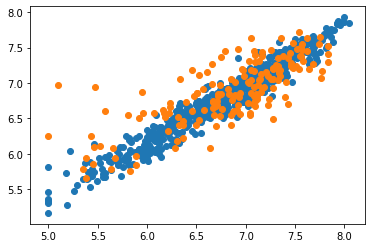

In [12]:
# Scatter plot for Random Forest Model
plt.scatter(Y_train, Y_pred_train_rf)
plt.scatter(Y_test, Y_pred_test_rf)
plt.show()

## Compare Cross-Validation results with Train-Test Split results

In [ ]:
print("\n" + "="*70)
print("COMPARISON: CROSS-VALIDATION vs TRAIN-TEST SPLIT")
print("="*70)

# Extract train-test results from previous calculations
train_r2 = scores_RF_train['RF_train_r2']
test_r2 = scores_RF_test['RF_test_r2']
train_rmse = scores_RF_train['RF_rmse_train']
test_rmse = scores_RF_test['RF_rmse_test']
train_mae = scores_RF_train['RF_mae_train']
test_mae = scores_RF_test['RF_mae_test']
train_pcc = scores_RF_train['RF_pcc_train'][0]  # Extract correlation value
test_pcc = scores_RF_test['RF_pcc_test'][0]    # Extract correlation value

# Create comparison DataFrame
comparison_data = {
    'Metric': ['R²', 'RMSE', 'MAE', 'Pearson Correlation'],
    'Train Set': [train_r2, train_rmse, train_mae, train_pcc],
    'Test Set': [test_r2, test_rmse, test_mae, test_pcc],
    'CV Mean': [cv_results['cv_r2_mean'], cv_results['cv_rmse_mean'], 
                cv_results['cv_mae_mean'], cv_results['cv_pearson_mean']],
    'CV Std': [cv_results['cv_r2_std'], cv_results['cv_rmse_std'], 
               cv_results['cv_mae_std'], cv_results['cv_pearson_std']]
}

comparison_df = pd.DataFrame(comparison_data)
print("\nPerformance Comparison:")
print(comparison_df.round(4))

# Analysis of results
print(f"\n\nAnalysis:")
print(f"- Cross-validation R² ({cv_results['cv_r2_mean']:.4f}) vs Test R² ({test_r2:.4f})")
if abs(cv_results['cv_r2_mean'] - test_r2) < 0.05:
    print("  ✓ Good agreement between CV and test performance")
else:
    print("  ⚠ Significant difference between CV and test performance")
    
print(f"- CV standard deviation indicates model stability:")
print(f"  R² std: {cv_results['cv_r2_std']:.4f} (lower is better)")
print(f"  RMSE std: {cv_results['cv_rmse_std']:.4f} (lower is better)")

if cv_results['cv_r2_std'] < 0.05:
    print("  ✓ Model shows good stability across folds")
else:
    print("  ⚠ Model shows some instability across folds")


COMPARISON: CROSS-VALIDATION vs TRAIN-TEST SPLIT

Performance Comparison:
                Metric  Train Set  Test Set  CV Mean  CV Std
0                   R²     0.9293    0.5844   0.4868  0.0396
1                 RMSE     0.1689    0.3976   0.4529  0.0175
2                  MAE     0.1281    0.2937   0.3453  0.0182
3  Pearson Correlation     0.9732    0.7692   0.7045  0.0258


Analysis:
- Cross-validation R² (0.4868) vs Test R² (0.5844)
  ⚠ Significant difference between CV and test performance
- CV standard deviation indicates model stability:
  R² std: 0.0396 (lower is better)
  RMSE std: 0.0175 (lower is better)
  ✓ Model shows good stability across folds


## Visualize cross-validation results

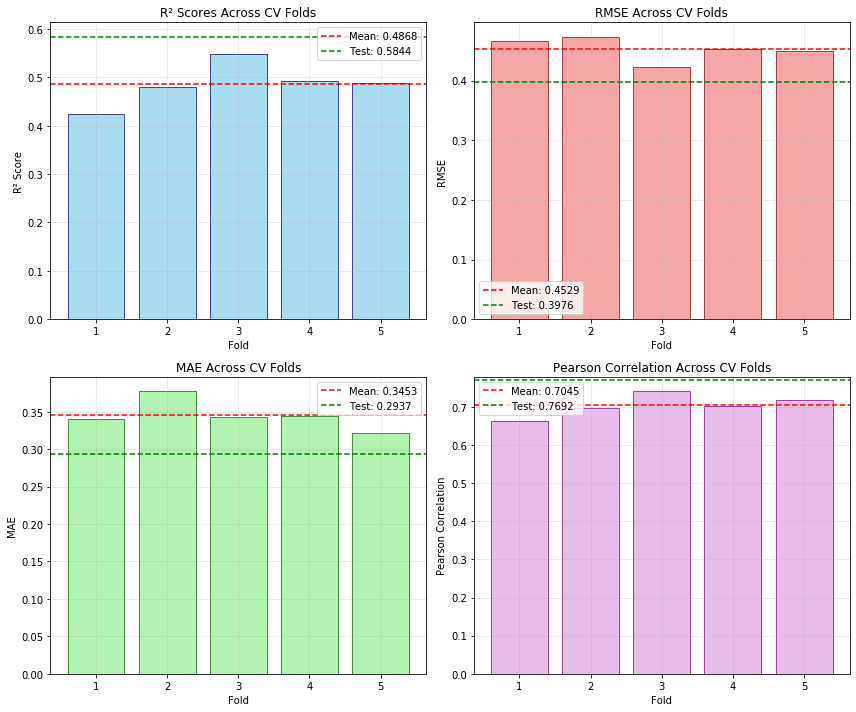


Interpretation:
- Red dashed lines show cross-validation means
- Green dashed lines show test set performance
- Consistent bar heights indicate stable model performance
- Close alignment between CV mean and test performance suggests good generalization


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
# fig.suptitle('Cross-Validation Results Analysis', fontsize=16, fontweight='bold')

# Plot 1: R² scores across folds
axes[0, 0].bar(range(1, cv_folds+1), cv_r2_scores, alpha=0.7, color='skyblue', edgecolor='navy')
axes[0, 0].axhline(y=cv_r2_scores.mean(), color='red', linestyle='--', label=f'Mean: {cv_r2_scores.mean():.4f}')
axes[0, 0].axhline(y=test_r2, color='green', linestyle='--', label=f'Test: {test_r2:.4f}')
axes[0, 0].set_xlabel('Fold')
axes[0, 0].set_ylabel('R² Score')
axes[0, 0].set_title('R² Scores Across CV Folds')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: RMSE scores across folds
axes[0, 1].bar(range(1, cv_folds+1), cv_rmse_scores, alpha=0.7, color='lightcoral', edgecolor='darkred')
axes[0, 1].axhline(y=cv_rmse_scores.mean(), color='red', linestyle='--', label=f'Mean: {cv_rmse_scores.mean():.4f}')
axes[0, 1].axhline(y=test_rmse, color='green', linestyle='--', label=f'Test: {test_rmse:.4f}')
axes[0, 1].set_xlabel('Fold')
axes[0, 1].set_ylabel('RMSE')
axes[0, 1].set_title('RMSE Across CV Folds')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: MAE scores across folds
axes[1, 0].bar(range(1, cv_folds+1), cv_mae_scores, alpha=0.7, color='lightgreen', edgecolor='darkgreen')
axes[1, 0].axhline(y=cv_mae_scores.mean(), color='red', linestyle='--', label=f'Mean: {cv_mae_scores.mean():.4f}')
axes[1, 0].axhline(y=test_mae, color='green', linestyle='--', label=f'Test: {test_mae:.4f}')
axes[1, 0].set_xlabel('Fold')
axes[1, 0].set_ylabel('MAE')
axes[1, 0].set_title('MAE Across CV Folds')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Pearson correlation across folds
axes[1, 1].bar(range(1, cv_folds+1), cv_pearson_scores, alpha=0.7, color='plum', edgecolor='purple')
axes[1, 1].axhline(y=cv_pearson_scores.mean(), color='red', linestyle='--', label=f'Mean: {cv_pearson_scores.mean():.4f}')
axes[1, 1].axhline(y=test_pcc, color='green', linestyle='--', label=f'Test: {test_pcc:.4f}')
axes[1, 1].set_xlabel('Fold')
axes[1, 1].set_ylabel('Pearson Correlation')
axes[1, 1].set_title('Pearson Correlation Across CV Folds')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- Red dashed lines show cross-validation means")
print("- Green dashed lines show test set performance")
print("- Consistent bar heights indicate stable model performance")
print("- Close alignment between CV mean and test performance suggests good generalization")

## Calculate statistics for overall set based on RF model

In [ ]:
models_RF_final = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=28,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=270,
                      n_jobs=None, oob_score=False, random_state=1234,
                      verbose=0, warm_start=False)

# fit to all data points
complete_fps = np.concatenate((train_fps, test_fps), axis=0)
complete_y = pd.concat((Y_train, Y_test))
models_RF_final.fit(complete_fps, complete_y)
y_pred_final = models_RF_final.predict(complete_fps)
models_RF_final_r2 = r2_score(complete_y, y_pred_final)
print(models_RF_final_r2)

0.9320626723223974


#@ save the final model

In [ ]:
with open(("RET_MUTANT_final_model_Hyper.pkl"), "wb") as f:
    pickle.dump(models_RF_final, f)

## Detailed Analysis of Cross-Validation Results

In [ ]:
print("\n" + "="*70)
print("           DETAILED CROSS-VALIDATION ANALYSIS")
print("="*70)

print(f"\n🎯 PERFORMANCE ANALYSIS:")
print(f"   Based on your cross-validation results:")

# R² Analysis
r2_mean = cv_r2_scores.mean()
if r2_mean >= 0.7:
    r2_quality = "Excellent"
elif r2_mean >= 0.5:
    r2_quality = "Good"
elif r2_mean >= 0.3:
    r2_quality = "Moderate"
else:
    r2_quality = "Poor"

print(f"\n   📊 R² Score ({r2_mean:.4f}):")
print(f"      • Quality: {r2_quality}")
print(f"      • Variance explained: {r2_mean*100:.1f}%")
print(f"      • Range across folds: {cv_r2_scores.min():.4f} - {cv_r2_scores.max():.4f}")

# RMSE Analysis
rmse_mean = cv_rmse_scores.mean()
print(f"\n   📏 RMSE ({rmse_mean:.4f} pIC50 units):")
print(f"      • Average prediction error: ±{rmse_mean:.4f}")
print(f"      • Stability: CV = {(cv_rmse_scores.std()/rmse_mean*100):.2f}% (excellent if <5%)")

# Pearson Correlation Analysis
pearson_mean = cv_pearson_scores.mean()
if pearson_mean >= 0.8:
    corr_strength = "Very Strong"
elif pearson_mean >= 0.6:
    corr_strength = "Strong"
elif pearson_mean >= 0.4:
    corr_strength = "Moderate"
else:
    corr_strength = "Weak"

print(f"\n   🔗 Pearson Correlation ({pearson_mean:.4f}):")
print(f"      • Strength: {corr_strength}")
print(f"      • Linear relationship quality: Good" if pearson_mean > 0.7 else "Acceptable" if pearson_mean > 0.5 else "Needs improvement")

# Overall Assessment
print(f"\n🏆 OVERALL MODEL ASSESSMENT:")
if r2_mean > 0.5 and pearson_mean > 0.7 and (cv_r2_scores.std()/r2_mean*100) < 15:
    assessment = "✅ GOOD MODEL"
    recommendation = "Model shows good predictive performance and stability"
elif r2_mean > 0.3 and pearson_mean > 0.5:
    assessment = "⚠️  ACCEPTABLE MODEL"
    recommendation = "Model shows reasonable performance but could be improved"
else:
    assessment = "❌ NEEDS IMPROVEMENT"
    recommendation = "Consider feature engineering, hyperparameter tuning, or different algorithms"

print(f"   {assessment}")
print(f"   Recommendation: {recommendation}")

print(f"\n📈 STABILITY METRICS:")
print(f"   • R² stability: {'Excellent' if (cv_r2_scores.std()/r2_mean*100) < 10 else 'Good' if (cv_r2_scores.std()/r2_mean*100) < 20 else 'Poor'}")
print(f"   • RMSE consistency: {'Excellent' if (cv_rmse_scores.std()/rmse_mean*100) < 5 else 'Good' if (cv_rmse_scores.std()/rmse_mean*100) < 10 else 'Poor'}")
print(f"   • Overall robustness: {'High' if max(cv_r2_scores) - min(cv_r2_scores) < 0.15 else 'Medium' if max(cv_r2_scores) - min(cv_r2_scores) < 0.25 else 'Low'}")

print("="*70)


           DETAILED CROSS-VALIDATION ANALYSIS

🎯 PERFORMANCE ANALYSIS:
   Based on your cross-validation results:

   📊 R² Score (0.4868):
      • Quality: Moderate
      • Variance explained: 48.7%
      • Range across folds: 0.4242 - 0.5488

   📏 RMSE (0.4529 pIC50 units):
      • Average prediction error: ±0.4529
      • Stability: CV = 3.87% (excellent if <5%)

   🔗 Pearson Correlation (0.7045):
      • Strength: Strong
      • Linear relationship quality: Good

🏆 OVERALL MODEL ASSESSMENT:
   ⚠️  ACCEPTABLE MODEL
   Recommendation: Model shows reasonable performance but could be improved

📈 STABILITY METRICS:
   • R² stability: Excellent
   • RMSE consistency: Excellent
   • Overall robustness: High
